The objective of this project is to simulate profits of selling call options when volatility is variable. In this project, I have taken the position of a call option seller. 

This project is in two parts:

In part I, I used the Heston model to model stock paths with variable volatility. Using Heston model call pricing, I estimated a minimum/maximum profit while delta hedging with n steps. 

In part II, I implemented delta-vega hedging (source theory: Mathematics for Finance, Capinski and Zastawniak). I then compared the effects of delta-vega hedging to no hedging, and also to simply a delta hedge. 

Observation: It appears that it is not standard to do a "sigma-hedge". People usually use a delta-gamma hedge or a delta-vega hedge to manage the effects of volatility. Hedging with respect to volatility, in the majority of strategies, appears to involve the buying of other options or variance exchanges.

In [2]:
#Package Import
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.optimize import brentq
from mpl_toolkits.mplot3d import Axes3D
sns.set_style('darkgrid')



Part I: Profits with Delta Hedging vs Without

In the below code, I used a fixed set of parameters for the Heston stock model. I used the Heston model to simulate 40,000 stock paths with variable volatility with 1,000 call options sold. I then compared the profit of selling call options with and without delta hedging. 

In [3]:
options_sold =100

#Compare Delta Hedging vs without hedging in a Heston Stock model 
def heston_call_MC_comparison(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=250000, mu=0):
    """
    Monte-Carlo Simulation of Call Option under Heston model with Black-Scholes Delta control variates vs without 
    Delta hedging
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - call_payouts (ndarray): Simulated payouts of a call-option
    """
    
    
    paths, vols = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu, return_vol=True)
    premium = heston_call(S0, K, v0, r, 0, kappa, theta, xi, rho)
    dt = t / n_steps

    # Compute BS deltas from previous steps volatility across all steps (n_steps, n_sims)
    # This is only an approximation of Delta of call option under Heston model.
    # The black-scholes deltas and Heston deltas are correlated enough so that black-scholes deltas
    # still work as a control variate in Monte-Carlo Simulation of Heston model option pricing
    
    deltas = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T  
    
    # Stock P&L from delta hedge
    stock_profits_steps_delta = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * deltas * np.exp(-r * np.arange(1, n_steps + 1) * dt)
    stock_profits_delta = np.sum(stock_profits_steps_delta, axis=1)
    call_payouts= np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    # Stock P&L without hedging
    call_sold_profits_delta = options_sold*(-call_payouts + premium +stock_profits_delta)
    end_points = paths[:,-1]
    call_sold_profits =  options_sold*(premium - call_payouts)
    # Call payouts
   


    return call_sold_profits_delta, call_sold_profits

#Main parameters for Heston modelling
kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)
theta = .3**2 #Long run variance of log-returns
xi = .43 # Volatility of Volatility (Typical range .2 to 1)
v0 = .42**2 #Initial variance of log-returns
sigma = .42
rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)
S0 = 178.2 #Initial Stock Value
K = 200
t = 1 #Time horizon
n_steps = 252 #Number of steps in each simulation
r = .039 #Risk-free interest rate
n_sims = 40000 #Number of simulations
mu = .034 #Excess drift of log returns

#Delta hedging
x = heston_call_MC_comparison(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=2500, mu=0)[0]
#Without delta hedging
y =  heston_call_MC_comparison(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=2500, mu=0)[1]

loss_delta = min(x)
loss_reg = min(y)

win_delta = max(x)
win_reg = max(y)

print("max loss of Heston model when delta hedging:", loss_delta)
print("max loss of Heston model without delta hedging:", loss_reg)

print("max profit of Heston model when delta hedging:", win_delta)
print("max profit of Heston model without delta hedging:", win_reg)

print("expected profit when delta hedging:", np.mean(x))
print("expected profit without delta hedging", np.mean(y))

max loss of Heston model when delta hedging: -6205.963718941404
max loss of Heston model without delta hedging: -35597.66809489318
max profit of Heston model when delta hedging: 775.6683348526684
max profit of Heston model without delta hedging: -26.486699204390884
expected profit when delta hedging: -1809.8890186620981
expected profit without delta hedging -1968.2103630251013


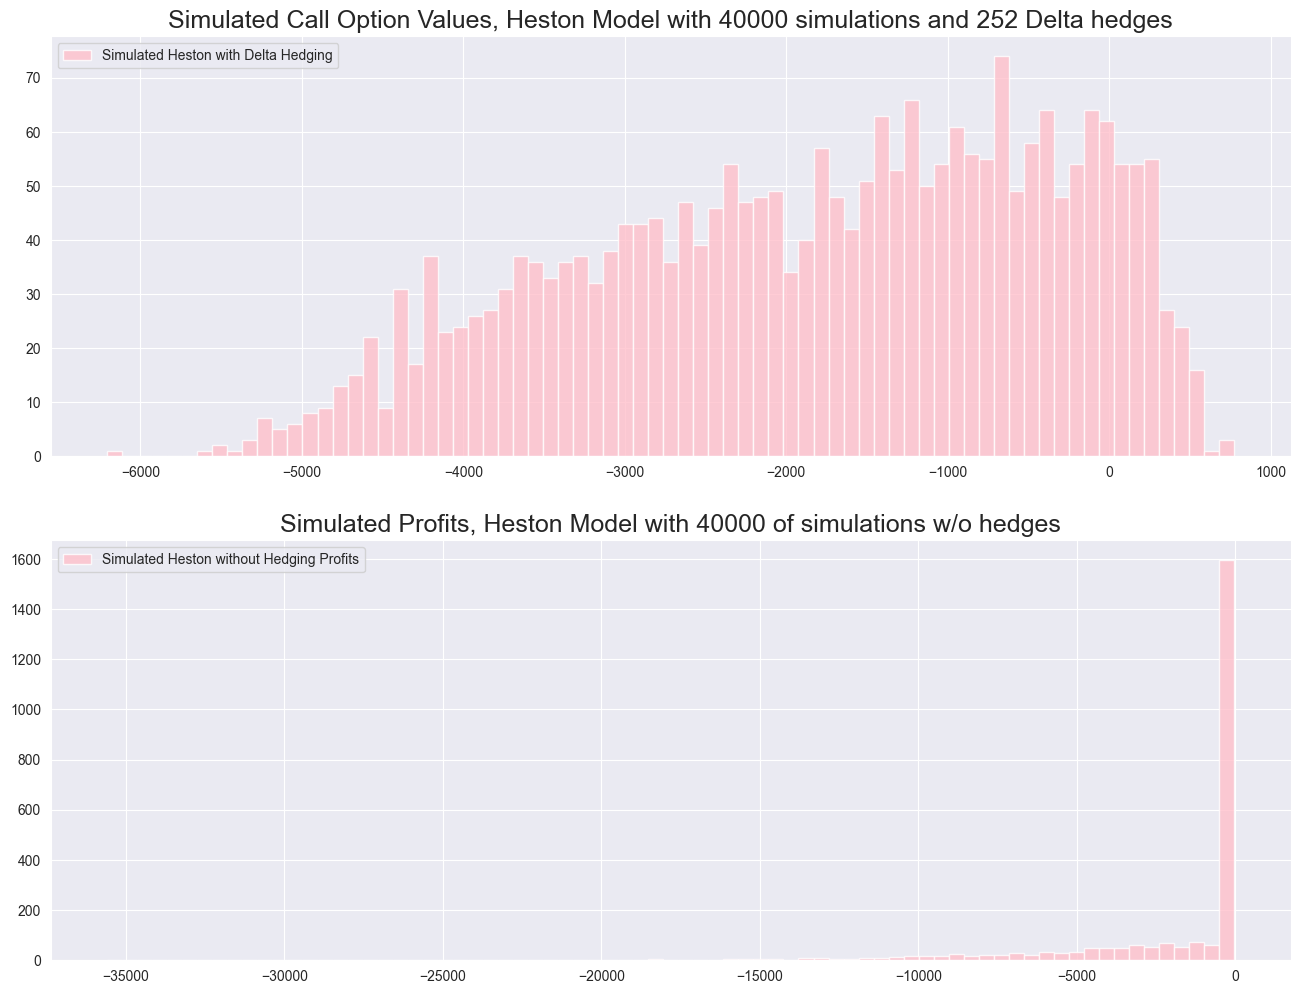

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1, figsize = (16,12))

axes[0].hist(x, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston with Delta Hedging')

axes[0].set_title(f'Simulated Call Option Values, Heston Model with {n_sims} simulations and {n_steps} Delta hedges', size = 18)

axes[0].legend()



axes[1].hist(y, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston without Hedging Profits')

axes[1].set_title(f'Simulated Profits, Heston Model with {n_sims} of simulations w/o hedges', size = 18)

axes[1].legend()

Delta hedging in this case does mitigate seller's the maximum loss relative to selling without hedging. However, even with delta hedging, on average, the seller is at a loss. Moreover, the maximum profit with delta hedging is dwarfed by the maximum loss. This indicates that delta hedging does not optimally account for the variable volatility

Part II:

From the point of view of the seller of call options for Stock X, in this part I have implemented a technique called Delta-Vega hedging. Vega represents the change in an option's call price with respect to the change in volatility. The idea is to buy/sell a call option of an additional stock, Stock Y, to balance the vega of the portfolio, while also buying/selling Stock X to balance the delta of the portfolio. 

I simulated an enormous number of stock movements for Stock X with the Heston stock movement with the set of parameters from Part I. Using the Heston model, I randomly generated an additional Stock Y with different, slightly less volatile parameters than the original set of parameters. The time to expiration for the call options for Stock is time 2, while the call options for Stock X expires in time 1. 

A major caveat to this set-up is that, in practice, one would have access to many options for Stock Y. Ideally, one would choose Stock Y to have certain desirable characteristics to optimally balance Delta/Vega, subject to the constaints of the current market. As I have used the Heston call option pricing for each stock path of Stock Y, which is computationally very expensive, I have simplified the simulation to only one random choice for Stock Y. I have also assumed constant risk-free interest and no-fee transactions, and that I was not the seller of the call options for Stock Y. 

How to Delta-Vega Hedge:
Let my profit at step n be represented by 

                number of Stock X shares owned *Stock price + money lost so far - sold options * initial Call price + z*Call price of Stock Y


At a step n, let DeltaX(n), VegaX(n) represent the deltas and vegas of the call price of Stock X
and let DeltaY(n), VegaY(n) represent the deltas and vegas of the call price of Stock X. 

The Delta of the profit at step n is 

                    x - sold options * DeltaX(n) + z*DeltaY(n)

where x is the choice of number of shares of Stock X to hold
To hedge, we want the Delta value to equal 0
The Vega of the profit at step n is

                    sold options * VegaX(n) + z* VegaY(n)

where z is the choice of how many StockY call options to purchase.
We also want the value of the vega to be 0. 

Thus, we solve the system of equations above for x,z. 



In the code below, I have implemented 40,000 Heston stock models for Stock X with 252 hedges/steps. We assume 100 call options were sold. 

In [5]:
#Stock X simulations
dt = t/n_steps
n_steps = 252
n_sims = 40000
#Stock X
paths, vols = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu, return_vol=True)

#Call price at time 0 of Stock X
premium = heston_call(S0, K, v0, r, 0, kappa, theta, xi, rho)

#Parameters for Stock Y
kappa_diff = 1 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)
theta_diff = theta #Long run variance of log-returns
xi_diff = .2# Volatility of Volatility (Typical range .2 to 1)
v0_diff= .09**2#Initial variance of log-returns
sigma_diff = 11
rho_diff = rho #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)
S0_diff = S0 #Initial Stock Value
K_diff= K+10
t_diff = 2 #Time horizon
r_diff = r #Risk-free interest rate
mu_diff = mu #Excess drift of log returns
n_sims_diff = 1

#Stock Y
diff_paths, diff_vols = heston_path_sim(S0_diff, v0_diff, r_diff, t_diff, n_steps, kappa_diff, theta_diff, xi_diff, rho_diff, n_sims_diff, mu_diff, return_vol=True)

#Find deltas, vegas for call prices of Stock X, Stock Y
deltas_original = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T  
deltas_fixed = np.array([bs_call_delta(diff_paths[:, i], K, np.sqrt(diff_vols[:,i]), t_diff - i * dt, r) for i in range(n_steps)]).T  
vegas_original = np.array([bs_vega(paths[:, i], K, np.sqrt(vols[:,i]), t-i*dt, r) for i in range(n_steps)]).T
vegas_fixed = np.array([bs_vega(diff_paths[:, i], K, np.sqrt(diff_vols[:,i]), t_diff-i*dt, r) for i in range(n_steps)]).T

#Find the call prices for Stock Y at each step
call_prices_fixed = np.zeros((1, n_steps+1))
for i in range(n_sims_diff):
         for j in range(n_steps):
            call_prices_fixed[i, j] = heston_call(diff_paths[i,j], K, diff_vols[i, j], r, t_diff - i * dt, kappa, theta, xi, rho)


In [6]:
options_sold =100


#Solve the Delta-Vega system at each step
delta_solutions = np.zeros((n_sims, n_steps))
CO_solutions  = np.zeros((n_sims, n_steps))   
for i in range(n_sims):
        for j in range(n_steps):
            A = [[1,deltas_fixed[0,j]], [0, vegas_fixed[0,j]]]
            b = [deltas_original[i,j]*options_sold, vegas_original[i,j]*options_sold]
            sol = np.linalg.solve(A,b)
            delta_solutions[i,j] = np.round(sol[0], 2)
            CO_solutions[i,j] = np.round(sol[1], 2)

#Count profits of stocks and call options and losses from call payouts
stock_profits_steps_delta = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * delta_solutions* np.exp(-r * np.arange(1, n_steps + 1) * dt)
stock_profits_delta = np.sum(stock_profits_steps_delta, axis=1)
bought_call_payout = (call_prices_fixed[:, 1:]-np.exp(r*dt)*call_prices_fixed[:,:-1])*CO_solutions*np.exp(-r *np.arange(1,n_steps+1)*dt)
bought_call_profits = np.sum(bought_call_payout, axis = 1)
call_payouts = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

#Calculate profits
profit = (premium - call_payouts) +stock_profits_delta + bought_call_profits



In [7]:
#delta hedging simulation of the same stocks
deltas_only = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T   
stock_profits_steps_delta_only = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * deltas_only * np.exp(-r * np.arange(1, n_steps + 1) * dt)
stock_profits_delta_only = np.sum(stock_profits_steps_delta_only, axis=1)
call_payouts= np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)
call_sold_profits_delta_only = options_sold*(-call_payouts + premium +stock_profits_delta_only)

In [8]:
call_sold_profits_no_hedge =  options_sold*(premium - call_payouts)
 

print(f'The maximum no-hedge profit is {max(call_sold_profits_no_hedge)}')
print(f'The minimum no-hedge profit is {min(call_sold_profits_no_hedge)}')
print(f'The expected no-hedge profit is {np.mean(call_sold_profits_no_hedge)}')
print(f'The standard deviation of the no-hedge profit is {np.std(call_sold_profits_no_hedge)}')
print('-------'*10)

print(f'The maximum Delta-Vega profit is {max(profit)}')
print(f'The minimum Delta-Vega profit is {min(profit)}')
print(f'The expected Delta-Vega profit is {np.mean(profit)}')
print(f'The standard deviation of the Delta-Vega profit is {np.std(profit)}')
print('-------'*10)

print(f'The maximum Delta profit is {max(call_sold_profits_delta_only)}')
print(f'The minimum Delta profit is {min(call_sold_profits_delta_only)}')
print(f'The expected Delta profit is {np.mean(call_sold_profits_delta_only)}')
print(f'The standard deviation of the Delta profit is {np.std(call_sold_profits_delta_only)}')

The maximum no-hedge profit is -26.486699204390884
The minimum no-hedge profit is -32656.381408153033
The expected no-hedge profit is -2119.1959954735903
The standard deviation of the no-hedge profit is 3644.5274845571425
----------------------------------------------------------------------
The maximum Delta-Vega profit is 11187.203556857163
The minimum Delta-Vega profit is -4047.0261130457816
The expected Delta-Vega profit is 93.61771057501859
The standard deviation of the Delta-Vega profit is 1212.639979221431
----------------------------------------------------------------------
The maximum Delta profit is 882.0444834484463
The minimum Delta profit is -7555.65513762088
The expected Delta profit is -1794.9730774882134
The standard deviation of the Delta profit is 1441.822471367393


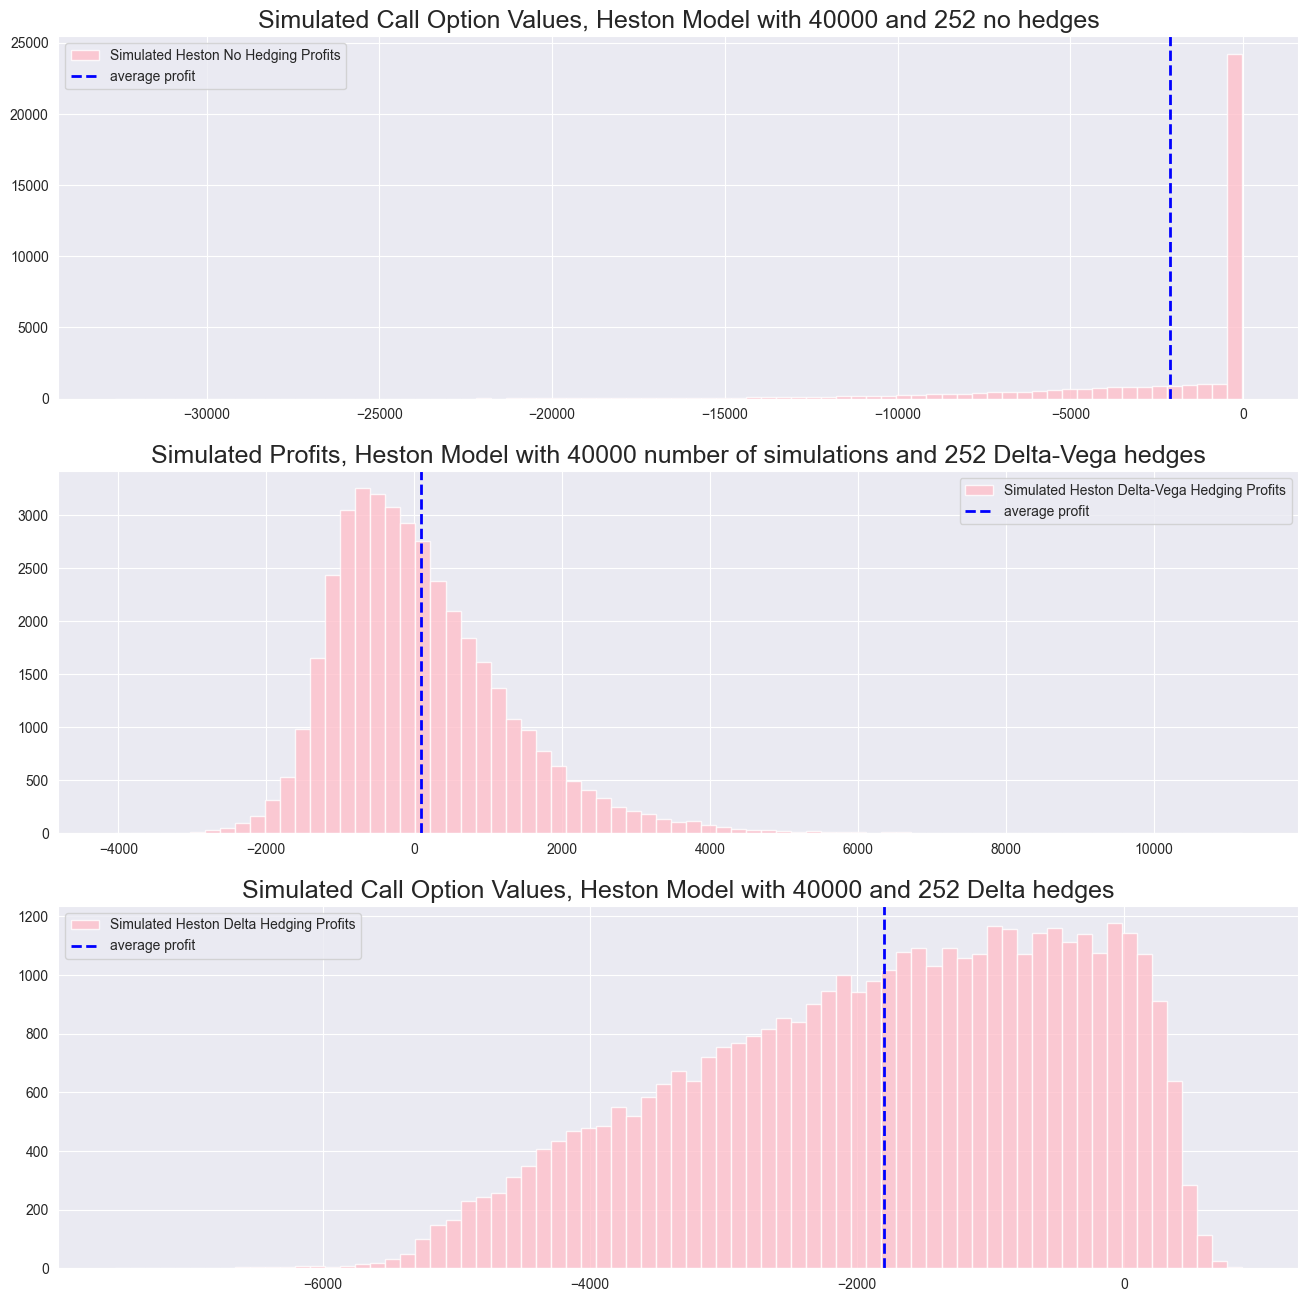

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,1, figsize = (16,16))

axes[0].hist(call_sold_profits_no_hedge, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston No Hedging Profits')
axes[0].axvline(x = np.mean(call_sold_profits_no_hedge), color  = 'blue', linestyle = '--', linewidth = 2, label = 'average profit')
axes[0].set_title(f'Simulated Call Option Values, Heston Model with {n_sims} and {n_steps} no hedges', size = 18)

axes[0].legend()




axes[1].hist(profit, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston Delta-Vega Hedging Profits')
axes[1].axvline(x = np.mean(profit), color  = 'blue', linestyle = '--', linewidth = 2, label = 'average profit')
axes[1].set_title(f'Simulated Profits, Heston Model with {n_sims} number of simulations and {n_steps} Delta-Vega hedges', size = 18)
axes[1].legend()


axes[2].hist(call_sold_profits_delta_only, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston Delta Hedging Profits')
axes[2].axvline(x = np.mean(call_sold_profits_delta_only), color  = 'blue', linestyle = '--', linewidth = 2, label = 'average profit')
axes[2].set_title(f'Simulated Call Option Values, Heston Model with {n_sims} and {n_steps} Delta hedges', size = 18)

axes[2].legend()



plt.show()

Conclusions: 
Delta hedging is still an improvement relative to not hedging at all. 
However, Delta-Vega hedging mitigates more loss than delta hedging alone. Maximum and average profits of Delta-Vega hedging are also improvements on Delta-hedging. This indicates that Delta-Vega hedging is a more attractive strategy for a seller of a call option with variable volatility. However, depending on the parameters of Stock X, one may need to find an appropriate Stock Y to maximize the effects of Delta-Vega hedging. Practical considerations may also impact the effects of Delta-Vega hedging. For example, when market prices of call prices for Stock Y are vastly above the Black-Schols calculation, this will greatly affect the profits/losses associated with Delta-Vega hedging. 

In [10]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.integrate import quad



def bs_call(S0, K, sigma, t, r = 0):
    """
    Computes the Black-Scholes price of a European call option.

    Parameters:
        S0 (float): Current asset price
        K (float): Strike price
        sigma (float): Annualized volatility (standard deviation of log returns)
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate (annualized)

    Returns:
        float: Call option price
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    call_price = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    return call_price


def bs_put(S0, K, sigma, t, r=0):
    """
    Description:
    
    Computes the Black-Scholes value of a European put option.
    
    Parameters:
        S0: Current asset price
        K: Strike price
        sigma: Yearly standard deviation of log-returns (volatility)
        t: Time to expiration (in years)
        r: Risk-free interest rate
    
    Returns:
        Put option price
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    put_price = -S0*norm.cdf(-d1) + K*np.exp(-r*t)*norm.cdf(-d2)
    return put_price
    
    
       


def bs_call_delta(S0, K, sigma, t, r):
    """
    Returns the Delta (sensitivity to spot price) of a European call option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Delta of Call Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*np.sqrt(t)/(sigma))
    return norm.cdf(d1)


def bs_put_delta(S0, K, sigma, t, r):
    """
    Returns the Delta (sensitivity to spot price) of a European put option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Delta of Put Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1) - 1.



def bs_gamma(S0,K,sigma,t,r):
    """
    Returns the Gamma (second order rate of change with respect to spot price) of a European call and put options
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Gamma of Call and Put Option
    """
    
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    
    return norm.pdf(d1)/(S0*sigma*np.sqrt(t))


def bs_vega(S0,K,sigma,t,r):
    """
    Returns the vega (rate of change with respect to volatility) of a European call and put options
    under Black-Scholes assumptions.
    
    To express vega as a percentage change, divide return by 100.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Vega of Call and Put Option
    """
    
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*np.sqrt(t)/(sigma))
    
    return S0*norm.pdf(d1)*np.sqrt(t)


def bs_call_theta(S0,K,sigma,t,r):
    """
    Returns the theta (rate of change with respect to time) of a European call option
    under Black-Scholes assumptions.
    
    
    To give daily theta, divide return by 252.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Theta of Call option
    """
    
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    return (-S0*norm.pdf(d1)*sigma)/(2*np.sqrt(t)) - r*K*np.exp(-r*t)*norm.cdf(d2)


def bs_put_theta(S0,K,sigma,t,r):
    """
    Returns the theta (rate of change with respect to time) of a European put option
    under Black-Scholes assumptions.
    
    
    To give daily theta, divide return by 252.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Theta of Put option
    """
    
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    return (-S0*norm.pdf(d1)*sigma)/(2*np.sqrt(t)) + r*K*np.exp(-r*t)*norm.cdf(-d2)


def bs_call_rho(S0,K,sigma,t,r):
    """
    Returns the rho (rate of change with respect to risk-free interest) of a European call option
    under Black-Scholes assumptions.
    

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Rho of call option
    """
    
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    return K*t*np.exp(-r*t)*norm.cdf(d2)


def bs_put_rho(S0,K,sigma,t,r):
    """
    Returns the rho (rate of change with respect to risk-free interest) of a European put option
    under Black-Scholes assumptions.
    

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Rho of put option
    """
    
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    return -K*t*np.exp(-r*t)*norm.cdf(-d2)


def gbm_path_sim(S0, sigma, t, r, mu= 0, n_sims = 1, n_steps = 1):
    """
    Simulation of stock path movements as Geometric Brownian Motion.
    
    Parameters:
    - S0 (float): Initial stock price
    - sigma (float): yearly volatility
    - t (float): Total time horizon (in years)
    - r (float): Risk-free interest rate
    - mu (float): Excess drift of log-returns
    - n_steps (int): Number of time steps
    - n_sims (int): Number of simulated paths

    Returns:
    - paths (ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1)
    """
    
    dt = t/n_steps
    
    noise = np.random.normal(0,1,size = (n_sims, n_steps))
    
    increments_log_returns = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    log_returns = np.cumsum(increments_log_returns, axis = 1)
    
    paths = S0*np.exp(log_returns)
    
    paths = np.insert(paths, 0, S0, axis = 1)
   
    return paths

def bs_MC_call_delta(S0, K, sigma, t, r, delta_sims = int(250)):
    """Description: 
    Monte-Carlo Simulation of Black-Scholes Call Delta
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (float): volatility
    t (float): time to expiration
    r (float): risk-free interest rate
    delta_sims (int): Number of simulations
    
    Return
    float: simulated delta of call option
    
    """
    bump = .01*S0 #epsilon in above estimation

    noise = np.random.normal(0,1,delta_sims)

    log_returns = (r-.5*sigma**2)*t + sigma*np.sqrt(t)*noise

    paths_up = (S0+bump)*np.exp(log_returns)

    paths_down = (S0-bump)*np.exp(log_returns)

    calls_up = np.maximum(paths_up - K, 0)*np.exp(-r*t)

    calls_down = np.maximum(paths_down - K, 0)*np.exp(-r*t)

    delta_sims = (calls_up - calls_down)/(2*bump)


    delta_estimate = np.mean(delta_sims)

    return delta_estimate


def bs_MC_call_delta_array(S, K, sigma, t, r, delta_sims = 250):
    """Description: 
    Monte-Carlo Simulation of Black-Scholes Call Deltas in an array
    
    Parameters:
    S (np.array of floats): spot prices
    K (float): strike price
    sigma (float): volatility
    t (float): time to expiration
    r (float): risk-free interest rate
    delta_sims (int): Number of simulations
    
    Return
    float: simulated delta of call option
    
    """
    
    bump = .01*S #epsilon in above estimation

    noise = np.random.normal(0,1,(delta_sims,len(S)))

    log_returns = (r-.5*sigma**2)*t + sigma*np.sqrt(t)*noise

    paths_up = (S+bump)*np.exp(log_returns)

    paths_down = (S-bump)*np.exp(log_returns)

    calls_up = np.maximum(paths_up - K, 0)*np.exp(-r*t)

    calls_down = np.maximum(paths_down - K, 0)*np.exp(-r*t)

    delta_sims = (calls_up - calls_down)/(2*bump)


    delta_estimate = np.mean(delta_sims, axis=0)
    

    return delta_estimate

def bs_MC_call(S0, K, sigma, t, r, mu = 0, n_sims = 2500, n_hedges = 50, delta_sims = 250):
    
    """Description
    Monte-Carlo simulation of the Black-Scholes value of a call option with Delta based control variants
    
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (float): volatility
    r (float): risk-free interest rate
    t (float): time to expiration
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): number of delta control variants at evenly spaced increments
    
    
    Return:
    np.array of simulated values of Black-Scholes value of call option
    """
    noise = np.random.normal(0,1,(n_sims,n_hedges))


    #time interval between each step in simulated path
    dt = t/n_hedges

    increments = (mu+r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise #log_return increments

    log_returns = np.cumsum(increments, axis = 1)

    paths = S0*np.exp(log_returns)



    #Simulate call payouts discounted to time 0

    path_end_points = paths[:,-1]

    call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)



    #Simulate stock profits at each interval

    ## profit from start to first step discounted to time 0
    ### We are going to cheat at the current moment in our simulation
    ### We will use the Black-Scholes formula to find Delta,
    ### We'll simulate Delta later

    delta_start = bs_MC_call_delta(S0,K,sigma,t,r,delta_sims)

    paths_first_steps = paths[:,0]

    first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*delta_start*np.exp(-dt*r)

    stock_profits = []

    stock_profits.append(first_stock_profits)




    ## stock profits in intermediate steps

    for i in range(1,n_hedges):
        stock_start = paths[:,i-1]
        stock_end = paths[:,i]
        tte = t-i*dt
        deltas = bs_MC_call_delta_array(stock_start, K, sigma, tte, r,delta_sims)


        stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)


        stock_profits.append(stock_profit)


    total_stock_profit = np.sum(stock_profits, axis = 0)

    profits_hedged = call_payouts - total_stock_profit
    
    
    return profits_hedged


def bs_MC_put_delta(S0, K, sigma, t, r, delta_sims = int(250)):
    """Description: 
    Monte-Carlo Simulation of Black-Scholes Call Delta
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (float): volatility
    t (float): time to expiration
    r (float): risk-free interest rate
    delta_sims (int): Number of simulations
    
    Return
    float: simulated delta of call option
    
    """
    bump = .01*S0 #epsilon in above estimation

    noise = np.random.normal(0,1,delta_sims)

    log_returns = (r-.5*sigma**2)*t + sigma*np.sqrt(t)*noise

    paths_up = (S0+bump)*np.exp(log_returns)

    paths_down = (S0-bump)*np.exp(log_returns)

    puts_up = np.maximum(-paths_up + K, 0)*np.exp(-r*t)

    puts_down = np.maximum(-paths_down + K, 0)*np.exp(-r*t)

    delta_sims = (puts_up - puts_down)/(2*bump)


    delta_estimate = np.mean(delta_sims)

    return delta_estimate


def bs_MC_put_delta_array(S, K, sigma, t, r, delta_sims = 250):
    """Description: 
    Monte-Carlo Simulation of Black-Scholes Call Deltas in an array
    
    Parameters:
    S (np.array of floats): spot prices
    K (float): strike price
    sigma (float): volatility
    t (float): time to expiration
    r (float): risk-free interest rate
    delta_sims (int): Number of simulations
    
    Return
    float: simulated delta of call option
    
    """
    
    bump = .01*S #epsilon in above estimation

    noise = np.random.normal(0,1,(delta_sims,len(S)))

    log_returns = (r-.5*sigma**2)*t + sigma*np.sqrt(t)*noise

    paths_up = (S+bump)*np.exp(log_returns)

    paths_down = (S-bump)*np.exp(log_returns)

    puts_up = np.maximum(-paths_up + K, 0)*np.exp(-r*t)

    puts_down = np.maximum(-paths_down + K, 0)*np.exp(-r*t)

    delta_sims = (puts_up - puts_down)/(2*bump)


    delta_estimate = np.mean(delta_sims, axis=0)
    

    return delta_estimate

def bs_MC_put(S0, K, sigma, t, r, mu = 0, n_sims = 2500, n_hedges = 50, delta_sims = 250):
    
    """Description
    Monte-Carlo simulation of the Black-Scholes value of a put option with Delta based control variants
    
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (float): volatility
    r (float): risk-free interest rate
    t (float): time to expiration
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): number of delta control variants at evenly spaced increments
    
    
    Return:
    np.array of simulated values of Black-Scholes value of call option
    """
    noise = np.random.normal(0,1,(n_sims,n_hedges))


    #time interval between each step in simulated path
    dt = t/n_hedges

    increments = (mu+r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise #log_return increments

    log_returns = np.cumsum(increments, axis = 1)

    paths = S0*np.exp(log_returns)



    #Simulate call payouts discounted to time 0

    path_end_points = paths[:,-1]

    put_payouts = np.maximum(-path_end_points + K,0)*np.exp(-r*t)



    #Simulate stock profits at each interval

    ## profit from start to first step discounted to time 0
    ### We are going to cheat at the current moment in our simulation
    ### We will use the Black-Scholes formula to find Delta,
    ### We'll simulate Delta later

    delta_start = bs_MC_put_delta(S0,K,sigma,t,r,delta_sims)

    paths_first_steps = paths[:,0]

    first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*delta_start*np.exp(-dt*r)

    stock_profits = []

    stock_profits.append(first_stock_profits)




    ## stock profits in intermediate steps

    for i in range(1,n_hedges):
        stock_start = paths[:,i-1]
        stock_end = paths[:,i]
        tte = t-i*dt
        deltas = bs_MC_put_delta_array(stock_start, K, sigma, tte, r,delta_sims)


        stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)


        stock_profits.append(stock_profit)


    total_stock_profit = np.sum(stock_profits, axis = 0)

    profits_hedged = put_payouts - total_stock_profit
    
    
    return profits_hedged

def bs_MC_call_fast(S0, K, sigma, t, r, mu = 0, n_sims = 2500, n_hedges = 50, delta_sims = 250):
    
    """Description
    Monte-Carlo simulation of payoffs of delta-hedged call option under Black-Scholes assumptions. 
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (float): volatility
    r (float): risk-free interest rate
    t (float): time to expiration
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): number of delta control variants at evenly spaced increments
    
    Return:
    np.array of simulated values of Black-Scholes value of call option with delta-hedging
    """
    
    #Random Noise for simulation
    noise = np.random.normal(0,1,(n_sims,n_hedges))

    #time interval between each step in simulated path
    dt = t/n_hedges
    increments = (mu+r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise #log_return increments
    log_returns = np.cumsum(increments, axis = 1)
    paths = S0*np.exp(log_returns)        
    paths = np.insert(S0,paths, 0)

    #Simulate call payouts discounted to time 0
    path_end_points = paths[:,-1]
    call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)

    #Simulate stock profits at each interval
    delta_start = bs_MC_call_delta(S0,K,sigma,t,r,delta_sims)
    paths_first_steps = paths[:,0]
    first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*delta_start*np.exp(-dt*r)
    stock_profits = []
    stock_profits.append(first_stock_profits)

    #Stock profits in intermediate steps
    for i in range(1,n_hedges):
        stock_start = paths[:,i-1]
        stock_end = paths[:,i]
        tte = t-i*dt
        deltas = bs_call_delta(stock_start, K, sigma, tte, r)
        stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)
        stock_profits.append(stock_profit)

    #Total stock profits from hedging and hedged call payouts
    total_stock_profit = np.sum(stock_profits, axis = 0)
    profits_hedged = call_payouts - total_stock_profit
        
    return profits_hedged






def implied_volatility_call(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a call option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        return bs_call(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan
    
def implied_volatility_put(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a put option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        return bs_put(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan

    
    
def heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=1, mu=0, return_vol=False):
    """
    Simulation of stock path movements under the Heston stochastic volatility model.
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - paths (ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1)
    - vols (ndarray, optional): Simulated variance paths if return_vol is True
    """
    dt = t / n_steps
    N1 = np.random.normal(0, 1, size=(n_sims, n_steps))
    N2 = np.random.normal(0, 1, size=(n_sims, n_steps))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    paths = np.zeros((n_sims, n_steps + 1))
    vols = np.zeros((n_sims, n_steps + 1))
    paths[:, 0] = S0
    vols[:, 0] = v0

    for i in range(n_steps):
        vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
                                xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
        paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * vols[:, i]) * dt +
                                               np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
    
    return (paths, vols) if return_vol else paths





def heston_call_MC(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=2500, mu=0):
    """
    Monte-Carlo Simulation of Call Option under Heston model with Black-Scholes Delta control variates
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - call_payouts (ndarray): Simulated payouts of a call-option
    """
    
    
    paths, vols = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu, return_vol=True)
    
    dt = t / n_steps

    # Compute BS deltas from previous steps volatility across all steps (n_steps, n_sims)
    # This is only an approximation of Delta of call option under Heston model.
    # The black-scholes deltas and Heston deltas are correlated enough so that black-scholes deltas
    # still work as a control variate in Monte-Carlo Simulation of Heston model option pricing
    
    deltas = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T  
    
    # Stock P&L from delta hedge
    stock_profits_steps = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * deltas * np.exp(-r * np.arange(1, n_steps + 1) * dt)
    stock_profits = np.sum(stock_profits_steps, axis=1)

    # Call payouts
    call_payouts = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    # Adjusted estimator
    call_payouts_hedged = call_payouts - stock_profits

    return call_payouts_hedged


def heston_put_MC(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims = 2500, mu=0):
    """
    Monte-Carlo Simulation of Put Option under Heston model with Black-Scholes Delta control variates
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - put_payouts (ndarray): Simulated payouts of a call-option
    """
    
    
    paths, vols = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu, return_vol=True)
    
    dt = t / n_steps

    # Compute BS deltas from previous steps volatility across all steps (n_steps, n_sims)
    # This is only an approximation of Delta of put option under Heston model.
    # The black-scholes deltas and Heston deltas are correlated enough so that black-scholes deltas
    # still work as a control variate in Monte-Carlo Simulation of Heston model option pricing
    deltas = np.array([
        bs_put_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r)
        for i in range(n_steps)
    ]).T  # shape: (n_sims, n_steps)
    
    # Stock P&L from delta hedge
    stock_profits_steps = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * deltas * np.exp(-r * np.arange(1, n_steps + 1) * dt)
    stock_profits = np.sum(stock_profits_steps, axis=1)

    # Put payouts
    put_payouts = np.maximum(-paths[:, -1] + K, 0) * np.exp(-r * t)

    # Adjusted estimator
    put_payouts_hedged = put_payouts - stock_profits

    return put_payouts_hedged


def heston_call(S0, K, v0, r, t, kappa, theta, xi, rho):
    """
    Price of a call option under Heston model
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions

    Returns:
    - call_price (float): Call option price
    """


    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)
        
        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    return call_price


def heston_put(S0, K, v0, r, t, kappa, theta, xi, rho):
    """
    Price of a European put option under the Heston model using put-call parity.

    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions

    Returns:
    - put_price (float): Put option price
    """

    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    
    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    put_price = call_price - S0 + K * np.exp(-r * t)  # via put-call parity

    return put_price
# %%

